In [11]:
import numpy as np

## Functions

In [13]:
def sigmoid(z):
    """ Sigmoid activation function."""
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
        """Derivative of the sigmoid function."""
        return sigmoid(z) * (1 - sigmoid(z))

def mse(y_pred, y):
    """Mean Squared Error (MSE) cost function."""
    return np.mean((y_pred - y) ** 2)

def mse_prime(y_pred, y):
    """Derivative of the Mean Squared Error (MSE) cost function."""
    return 2 * (y_pred - y) / y.shape[1]
    
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

def softmax_prime(z):
    s = softmax(z)
    return s * (1 - s)

## Neural network class

In [46]:
class NeuralNetwork:
    def __init__(self, layer_sizes):
        """
        Initialize the neural network with random weights and biases.
        
        Args:
            layer_sizes (list): List of integers specifying the number of neurons in each layer.
                               Example: [input_size, hidden_size, ..., output_size]
        """
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes)
        
        # Initialize weights and biases
        self.weights = [np.random.randn(y, x) for x, y in zip(layer_sizes[:-1], layer_sizes[1:])]
        self.biases = [np.random.randn(y, 1) for y in layer_sizes[1:]]
        

    def forward(self, X):
        # Reshape input to a column vector
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        
        self.a = [X] # List to store activations for each layer
        self.z = [] # List to store weighted inputs for each layer

        for l, (w, b) in enumerate(zip(self.weights, self.biases)):
            z = w @ self.a[-1] + b # Weighted input
            self.z.append(z) 

            # Use softmax for last layer sigmoid for hidden layers
            if l == len(self.biases) - 1: # Last layer (output)
                a = softmax(z) # Softmax for output
            else:
                a = sigmoid(z) # Sigmoid for hidden
            
            self.a.append(a) # Activation

        return self.a[-1] # Output of the network
    

    def backprop(self, y):
        """
        Compute gradients using backpropagation.
        
        Args:
            y: Target outputs of shape (output_size, batch_size).
        
        Returns:
            Tuple (grad_w, grad_b) containing gradients for each layer.
        """
        # Initialize gradient lists
        grad_w = [np.zeros_like(w) for w in self.weights]
        grad_b = [np.zeros_like(b) for b in self.biases]
        
        # Output layer error (delta_L)
        delta = mse_prime(self.a[-1], y) * softmax_prime(self.z[-1])
        # Store output layer gradients
        grad_w[-1] = delta @ self.a[-2].T
        grad_b[-1] = delta
        
        # Propagate error backward through hidden layers
        for l in reversed(range(len(self.weights) - 1)):
            # Calculate delta for current layer
            delta = (self.weights[l + 1].T @ delta) * sigmoid_prime(self.z[l])
            # Compute gradients
            grad_w[l] = delta @ self.a[l].T
            grad_b[l] = delta
        
        return grad_w, grad_b
        

    def update_parameters(self, grad_w, grad_b, eta, batch_size):
        """Update weights and biases using averaged gradients."""
        for l in range(len(self.weights)):
            self.weights[l] -= eta  * (grad_w[l] / batch_size)
            self.biases[l] -= eta * (grad_b[l] / batch_size)
            

    def train(self, x_train, y_train, epochs, batch_size, eta, results=False):
        """
        Train the network using mini-batch SGD.
        
        Args:
            x_train: Input data of shape (num_samples, input_size).
            y_train: Target outputs of shape (num_samples, output_size).
            epochs: Number of training epochs.
            batch_size: Size of mini-batches.
            eta: Learning rate.
        """
        num_samples = len(x_train)
        input_size = self.layer_sizes[0]
        output_size = self.layer_sizes[-1]
        
        for epoch in range(epochs):
            # Shuffle data
            indices = np.random.permutation(num_samples)
            X_shuffled = [x_train[i] for i in indices]
            y_shuffled = [y_train[i] for i in indices]

            # Initialize lists to store outputs and true labels
            if results:
                epoch_outputs = []
                epoch_labels = []
            
            # Process mini-batches
            for i in range(0, num_samples, batch_size):
                # Get mini-batch
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]
                
                # Initialize gradient arrays
                grad_w = [np.zeros_like(w) for w in self.weights]
                grad_b = [np.zeros_like(b) for b in self.biases]
                
                # Accumulate gradients over mini-batch
                for x, y_true in zip(X_batch, y_batch):
                    # Convert to column vectors
                    x = x.reshape(-1, 1)
                    y_true = y_true.reshape(-1, 1)

                    # Forward + Backprop
                    output = self.forward(x)
                    batch_grad_w, batch_grad_b = self.backprop(y_true)

                    if results:
                        epoch_outputs.append(output.flatten())  # Save output
                        epoch_labels.append(y_true.flatten())  # Save true label
                    
                    # Add to total gradients
                    for l in range(len(self.weights)):
                        grad_w[l] += batch_grad_w[l]
                        grad_b[l] += batch_grad_b[l]
                
                # Update parameters (gradients are averaged here)
                self.update_parameters(grad_w, grad_b, eta, batch_size)

            
            # Optional: Print progress
            if results: 
                epoch_outputs = np.array(epoch_outputs)
                epoch_labels = np.array(epoch_labels)
    
                loss = mse(epoch_outputs, epoch_labels)
    
                # Calculate accuracy
                predictions = np.argmax(epoch_outputs, axis=1)
                true_labels = np.argmax(epoch_labels, axis=1)
                accuracy = np.mean(predictions == true_labels)
    
                # Print progress
                print(f"Epoch: {epoch + 1}/{epochs}, Loss: {loss:.4f}, Accuracy: {accuracy * 100:.2f}%")


## Training

In [17]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data to the range [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Flatten the images (28x28 -> 784)
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [48]:
layer_sizes = [784, 128, 64, 10]
nn = NeuralNetwork(layer_sizes)

epochs = 30
batch_size = 64
eta = 0.8

nn.train(x_train, y_train, epochs, batch_size, eta, results=True)

Epoch: 1/30, Loss: 0.0552, Accuracy: 57.16%
Epoch: 2/30, Loss: 0.0266, Accuracy: 81.59%
Epoch: 3/30, Loss: 0.0203, Accuracy: 86.26%
Epoch: 4/30, Loss: 0.0171, Accuracy: 88.59%
Epoch: 5/30, Loss: 0.0151, Accuracy: 90.03%
Epoch: 6/30, Loss: 0.0137, Accuracy: 90.96%
Epoch: 7/30, Loss: 0.0127, Accuracy: 91.72%
Epoch: 8/30, Loss: 0.0118, Accuracy: 92.36%
Epoch: 9/30, Loss: 0.0111, Accuracy: 92.83%
Epoch: 10/30, Loss: 0.0105, Accuracy: 93.25%
Epoch: 11/30, Loss: 0.0099, Accuracy: 93.66%
Epoch: 12/30, Loss: 0.0094, Accuracy: 94.00%
Epoch: 13/30, Loss: 0.0090, Accuracy: 94.33%
Epoch: 14/30, Loss: 0.0086, Accuracy: 94.59%
Epoch: 15/30, Loss: 0.0083, Accuracy: 94.85%
Epoch: 16/30, Loss: 0.0079, Accuracy: 95.05%
Epoch: 17/30, Loss: 0.0076, Accuracy: 95.29%
Epoch: 18/30, Loss: 0.0073, Accuracy: 95.49%
Epoch: 19/30, Loss: 0.0071, Accuracy: 95.67%
Epoch: 20/30, Loss: 0.0069, Accuracy: 95.80%
Epoch: 21/30, Loss: 0.0066, Accuracy: 95.94%
Epoch: 22/30, Loss: 0.0065, Accuracy: 96.11%
Epoch: 23/30, Loss:

## Testing

Test Accuracy: 93.88%
Correct: 9388/10000

Misclassified Examples:
Network outputs: 
[0.00, 0.00, 0.00, 0.00, 0.19, 0.00, 0.80, 0.00, 0.00, 0.00]


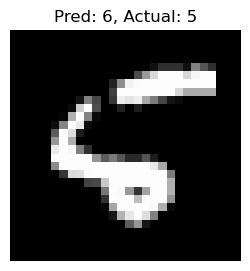


Network outputs: 
[0.00, 0.00, 0.00, 0.01, 0.00, 0.00, 0.00, 0.00, 0.99, 0.00]


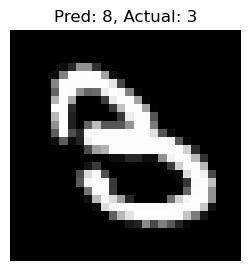


Network outputs: 
[0.04, 0.00, 0.00, 0.00, 0.34, 0.00, 0.62, 0.00, 0.00, 0.00]


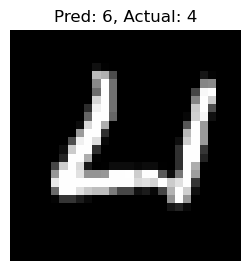


Network outputs: 
[0.00, 0.00, 0.74, 0.00, 0.00, 0.00, 0.00, 0.00, 0.25, 0.00]


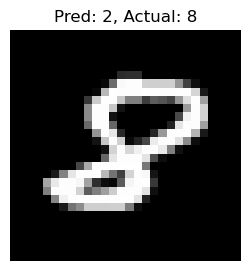


Network outputs: 
[0.00, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.54, 0.01, 0.44]


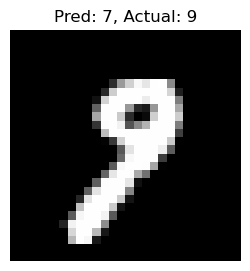


Network outputs: 
[0.00, 0.02, 0.40, 0.01, 0.00, 0.05, 0.00, 0.00, 0.51, 0.02]


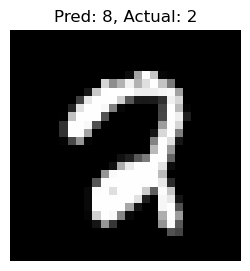


Network outputs: 
[0.32, 0.00, 0.02, 0.19, 0.00, 0.43, 0.00, 0.04, 0.00, 0.00]


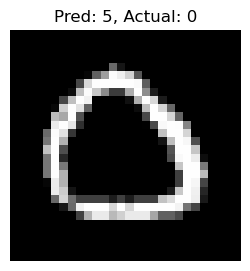


Network outputs: 
[0.00, 0.00, 0.03, 0.00, 0.15, 0.00, 0.00, 0.02, 0.00, 0.78]


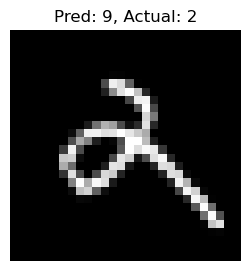


Network outputs: 
[0.03, 0.01, 0.33, 0.09, 0.00, 0.07, 0.00, 0.10, 0.07, 0.32]


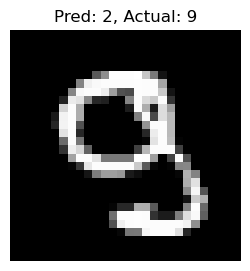


Network outputs: 
[0.00, 0.00, 0.00, 0.04, 0.00, 0.79, 0.00, 0.00, 0.00, 0.16]


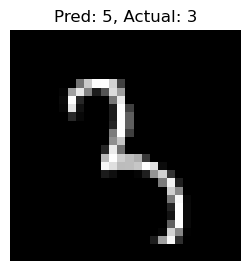


Network outputs: 
[0.00, 0.00, 0.00, 0.00, 0.36, 0.00, 0.01, 0.03, 0.00, 0.59]


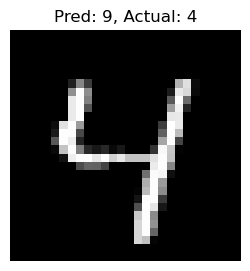


Network outputs: 
[0.03, 0.00, 0.00, 0.01, 0.00, 0.10, 0.00, 0.00, 0.84, 0.03]


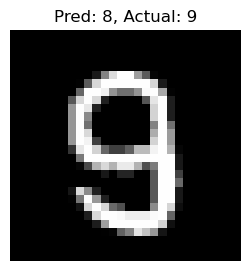


Network outputs: 
[0.00, 0.00, 0.42, 0.00, 0.26, 0.00, 0.31, 0.00, 0.00, 0.00]


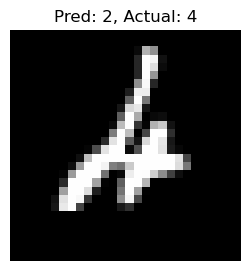


Network outputs: 
[1.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00]


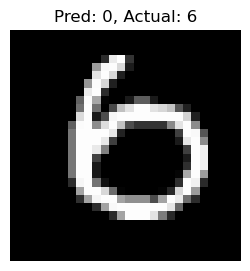


Network outputs: 
[0.00, 0.04, 0.00, 0.00, 0.00, 0.03, 0.02, 0.01, 0.59, 0.31]


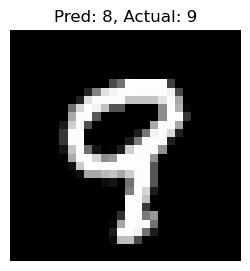


Network outputs: 
[0.00, 0.00, 0.00, 0.00, 0.06, 0.02, 0.00, 0.00, 0.91, 0.00]


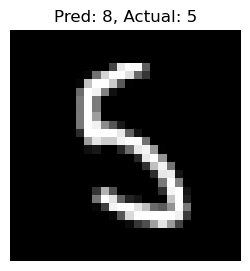


Network outputs: 
[0.00, 0.07, 0.01, 0.03, 0.00, 0.00, 0.00, 0.74, 0.00, 0.15]


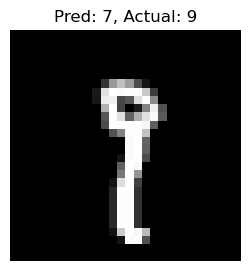


Network outputs: 
[0.00, 0.00, 0.30, 0.04, 0.00, 0.00, 0.00, 0.65, 0.01, 0.00]


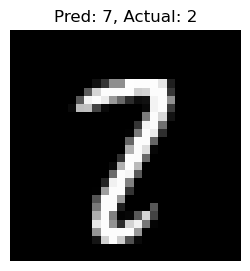


Network outputs: 
[0.00, 0.01, 0.00, 0.49, 0.00, 0.00, 0.00, 0.00, 0.49, 0.00]


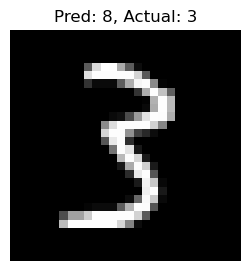


Network outputs: 
[0.00, 0.44, 0.06, 0.34, 0.00, 0.03, 0.10, 0.02, 0.00, 0.01]


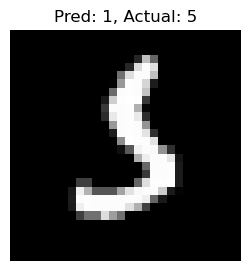


Network outputs: 
[0.00, 0.00, 0.31, 0.12, 0.00, 0.01, 0.00, 0.47, 0.01, 0.08]


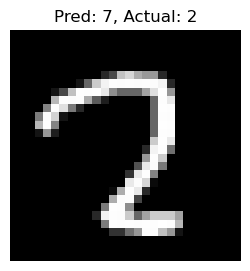


Network outputs: 
[0.00, 0.00, 0.00, 0.00, 0.34, 0.00, 0.00, 0.00, 0.00, 0.66]


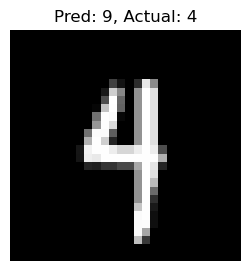


Network outputs: 
[0.41, 0.00, 0.00, 0.00, 0.00, 0.58, 0.00, 0.00, 0.00, 0.00]


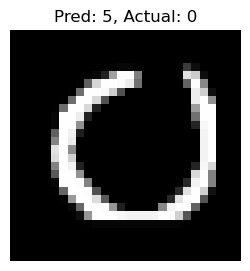


Network outputs: 
[0.00, 0.00, 0.03, 0.09, 0.00, 0.00, 0.00, 0.84, 0.00, 0.04]


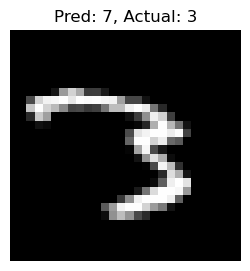


Network outputs: 
[0.00, 0.00, 0.00, 0.00, 0.00, 0.91, 0.01, 0.00, 0.07, 0.00]


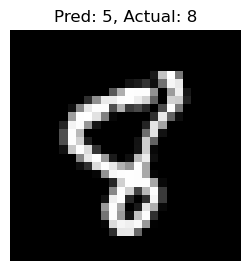

In [50]:
import matplotlib.pyplot as plt

def test_model(network, X_test, y_test, num_examples_to_show=5):
    # Convert one-hot encoded labels to integers
    true_labels = np.argmax(y_test, axis=1)
    
    # Initialize counters and storage
    correct = 0
    misclassified_indices = []
    all_predictions = []
    
    # Test all examples
    for i in range(len(X_test)):
        x = X_test[i].reshape(-1, 1)  # Reshape to column vector
        output = network.forward(x).flatten()
        prediction = np.argmax(output)
        actual = true_labels[i]
        
        all_predictions.append(prediction)
        if prediction == actual:
            correct += 1
        else:
            misclassified_indices.append(i)
    
    # Calculate accuracy
    accuracy = correct / len(X_test)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    print(f"Correct: {correct}/{len(X_test)}")
    
    # Show misclassified examples
    print("\nMisclassified Examples:")
    for i in misclassified_indices[:num_examples_to_show]:
        x = X_test[i]
        output = network.forward(x.reshape(-1, 1)).flatten()
        prediction = np.argmax(output)
        actual = true_labels[i]

        print(f"Network outputs: ")
        print(f"[{', '.join(f'{x:.2f}' for x in output)}]")
        
        plt.figure(figsize=(3, 3))
        plt.imshow(x.reshape(28, 28), cmap='gray')
        plt.title(f"Pred: {prediction}, Actual: {actual}")
        plt.axis('off')
        plt.show()
        
        print()

test_model(nn, x_test, y_test, num_examples_to_show=25)